In [ ]:
# Install necessary libraries if not already installed
!pip install pandas scikit-learn matplotlib seaborn

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO  # For parsing if needed, but assuming uploaded files

In [ ]:
# Step 1: Upload the CSV files to Colab (run this cell and upload files)
from google.colab import files
uploaded = files.upload()

Saving diets.csv to diets.csv
Saving medications.csv to medications.csv
Saving precautions_df.csv to precautions_df.csv
Saving symptoms_df.csv to symptoms_df.csv
Saving workout_df.csv to workout_df.csv


In [ ]:
# Step 2: Load the datasets
# Assuming uploaded files are named 'diet.csv', 'workout.csv', 'precaution.csv', 'medication.csv', 'symptoms.csv'
symptoms_df = pd.read_csv('symptoms_df.csv')
diets_df = pd.read_csv('diets.csv')
medications_df = pd.read_csv('medications.csv')
precautions_df = pd.read_csv('precautions_df.csv')
workout_df = pd.read_csv('workout_df.csv', names=['Unnamed: 0', 'disease', 'workout'], header=0)
# Clean up column names and drop unnecessary columns
symptoms_df = symptoms_df.drop(columns=[symptoms_df.columns[0]] if len(symptoms_df.columns) > 0 and symptoms_df.columns[0] == '' else [])
diets_df['Diet'] = diets_df['Diet'].apply(lambda x: eval(x) if isinstance(x, str) else x)
medications_df['Medication'] = medications_df['Medication'].apply(lambda x: eval(x) if isinstance(x, str) else x)
precautions_df = precautions_df.drop(columns=[precautions_df.columns[0]] if len(precautions_df.columns) > 0 and precautions_df.columns[0] == '' else [])
workout_df = workout_df[['disease', 'workout']]

In [ ]:
# Step 3: Preprocess symptoms data for training
# Collect all unique symptoms
symptom_columns = ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']
all_symptoms = set()
for col in symptom_columns:
    if col in symptoms_df.columns:
        all_symptoms.update(symptoms_df[col].dropna().unique().astype(str))
all_symptoms = list(all_symptoms)
print(f"Total unique symptoms: {len(all_symptoms)}")

# Create binary feature matrix (one-hot encoding for presence of symptoms)
X = pd.DataFrame(0, index=symptoms_df.index, columns=all_symptoms)
for idx, row in symptoms_df.iterrows():
    for col in symptom_columns:
        if col in row.index:
            sym = str(row[col])
            if sym and sym in all_symptoms:
                X.at[idx, sym] = 1

y = symptoms_df['Disease']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Total unique symptoms: 86


Model Accuracy: 1.00

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       0.96      1.00      0.98        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      0.96   

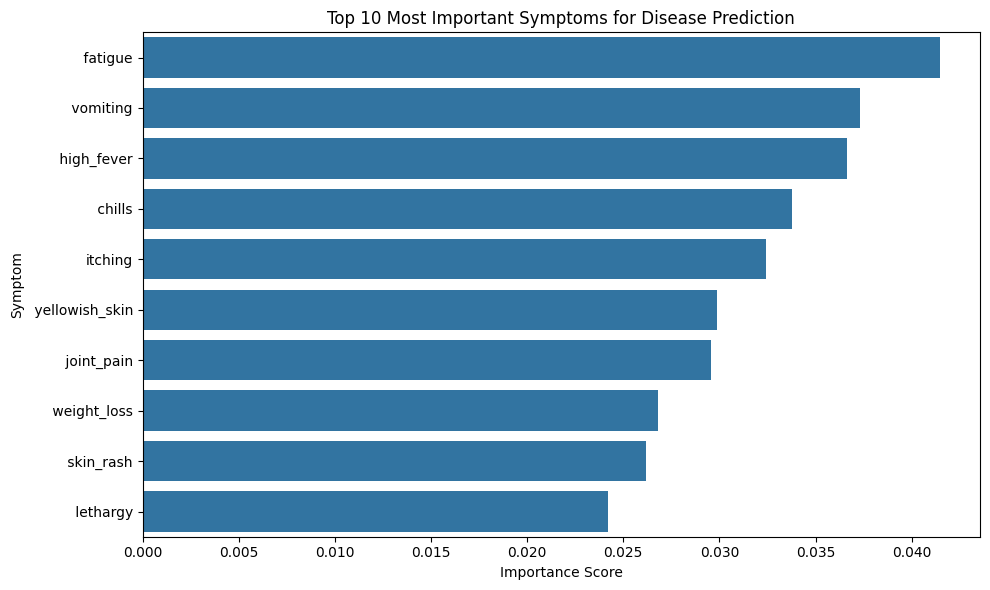

In [ ]:
# Step 4: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize feature importance (top 10 symptoms)
feature_importance = pd.DataFrame({
    'Symptom': all_symptoms,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Symptom')
plt.title('Top 10 Most Important Symptoms for Disease Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
# Step 5: Function to predict disease from user-input symptoms
def predict_disease(user_symptoms):
    """
    Predict disease based on list of symptoms.
    user_symptoms: list of strings, e.g., ['itching', 'skin_rash', 'stomach_pain']
    """
    input_vector = pd.DataFrame(0, index=[0], columns=all_symptoms)
    for sym in user_symptoms:
        sym_str = str(sym).strip()
        if sym_str in all_symptoms:
            input_vector[sym_str] = 1

    prediction = clf.predict(input_vector)[0]
    probabilities = clf.predict_proba(input_vector)[0]
    top_3 = sorted(zip(clf.classes_, probabilities), key=lambda x: x[1], reverse=True)[:3]

    return prediction, top_3

In [ ]:
# Step 6: Function to get recommendations for a disease
def get_recommendations(disease):
    # Diet
    diet_row = diets_df[diets_df['Disease'] == disease]
    diet = diet_row['Diet'].values[0] if not diet_row.empty else "No data available"

    # Medication
    med_row = medications_df[medications_df['Disease'] == disease]
    meds = med_row['Medication'].values[0] if not med_row.empty else "No data available"

    # Precautions
    prec_rows = precautions_df[precautions_df['Disease'] == disease]
    precautions = prec_rows[['Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']].values.flatten()
    precautions = [p for p in precautions if pd.notna(p) and str(p).strip() != '']

    # Workouts (collect all for the disease)
    workout_rows = workout_df[workout_df['disease'] == disease]
    workouts = workout_rows['workout'].tolist() if not workout_rows.empty else ["No data available"]

    return {
        'Diet': diet,
        'Medications': meds,
        'Precautions': precautions[:4],  # Limit to top 4
        'Workouts': workouts[:5]  # Limit to top 5
    }

In [ ]:
# Cell 1: Install necessary libraries
!pip install pandas scikit-learn matplotlib seaborn ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.3 MB/s eta 0:00:00


In [ ]:
# Cell 2: Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output, Markdown, HTML
import json  # For handling lists if needed

In [ ]:
# Cell 3: Upload the CSV files to Colab (run this cell and upload: symptoms.csv, diet.csv, medication.csv, precaution.csv, workout.csv)
from google.colab import files
uploaded = files.upload()

# Load the datasets
symptoms_df = pd.read_csv('symptoms_df.csv')
diets_df = pd.read_csv('diets.csv')
medications_df = pd.read_csv('medications.csv')
precautions_df = pd.read_csv('precautions_df.csv')
workout_df = pd.read_csv('workout_df.csv', names=['Unnamed: 0', 'disease', 'workout'], header=0)

# Clean up column names and drop unnecessary columns
symptoms_df = symptoms_df.dropna(axis=1, how='all')  # Drop empty columns
if symptoms_df.columns[0] == 'Unnamed: 0':
    symptoms_df = symptoms_df.drop(columns=[symptoms_df.columns[0]])

diets_df['Diet'] = diets_df['Diet'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [x])
if diets_df.columns[0] == 'Unnamed: 0':
    diets_df = diets_df.drop(columns=[diets_df.columns[0]])

medications_df['Medication'] = medications_df['Medication'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else [x])
if medications_df.columns[0] == 'Unnamed: 0':
    medications_df = medications_df.drop(columns=[medications_df.columns[0]])

precautions_df = precautions_df.dropna(axis=1, how='all')
if precautions_df.columns[0] == 'Unnamed: 0':
    precautions_df = precautions_df.drop(columns=[precautions_df.columns[0]])

# For workout_df, assume columns are 'Unnamed: 0', 'disease', 'workout' or similar; select 'disease' and 'workout'
if 'Unnamed: 0' in workout_df.columns:
    workout_df = workout_df.drop(columns=['Unnamed: 0'])
workout_df = workout_df.dropna(axis=1, how='all')
workout_df = workout_df[['disease', 'workout']]


print("Data loaded successfully!")
print(f"Symptoms shape: {symptoms_df.shape}")
print(f"Diets shape: {diets_df.shape}")
print(f"Medications shape: {medications_df.shape}")
print(f"Precautions shape: {precautions_df.shape}")
print(f"Workouts shape: {workout_df.shape}")

Saving diets.csv to diets (1).csv
Saving medications.csv to medications (1).csv
Saving precautions_df.csv to precautions_df (1).csv
Saving symptoms_df.csv to symptoms_df (1).csv
Saving workout_df.csv to workout_df (1).csv
Data loaded successfully!
Symptoms shape: (4920, 5)
Diets shape: (41, 2)
Medications shape: (41, 2)
Precautions shape: (41, 5)
Workouts shape: (410, 2)


In [ ]:
# Cell 4: Preprocess symptoms data for training
# Identify symptom columns (assuming 'Disease', 'Symptom_1', 'Symptom_2', etc.)
symptom_cols = [col for col in symptoms_df.columns if 'Symptom' in col]
disease_col = 'Disease'  # Assuming this is the column name

# Collect all unique symptoms
all_symptoms = set()
for col in symptom_cols:
    if col in symptoms_df.columns:
        all_symptoms.update(symptoms_df[col].dropna().unique().astype(str))
all_symptoms = sorted(list(all_symptoms))  # Sort for consistent order
print(f"Total unique symptoms: {len(all_symptoms)}")

# Create binary feature matrix
X = pd.DataFrame(0, index=symptoms_df.index, columns=all_symptoms)
for idx, row in symptoms_df.iterrows():
    for col in symptom_cols:
        if col in symptoms_df.columns:
            sym = str(row[col]).strip()
            if sym and sym in all_symptoms:
                X.at[idx, sym] = 1

y = symptoms_df[disease_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Store for later use
global model_data
model_data = {
    'clf': clf,
    'all_symptoms': all_symptoms,
    'symptom_cols': symptom_cols,
    'disease_col': disease_col
}

Total unique symptoms: 86
Model Accuracy: 0.05

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       0.00      0.00      0.00        24
                                   AIDS       0.00      0.00      0.00        24
                                   Acne       0.00      0.00      0.00        24
                    Alcoholic hepatitis       0.00      0.00      0.00        24
                                Allergy       0.00      0.00      0.00        24
                              Arthritis       0.00      0.00      0.00        24
                       Bronchial Asthma       0.00      0.00      0.00        24
                   Cervical spondylosis       0.00      0.00      0.00        24
                            Chicken pox       0.00      0.00      0.00        24
                    Chronic cholestasis       0.16      0.92      0.27        24
                            Common Co

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Cell 5: Define functions for prediction and recommendations
def predict_disease(user_symptoms):
    input_vector = pd.DataFrame(0, index=[0], columns=model_data['all_symptoms'])
    for sym in user_symptoms:
        sym_str = str(sym).strip()
        if sym_str in model_data['all_symptoms']:
            input_vector[sym_str] = 1

    prediction = model_data['clf'].predict(input_vector)[0]
    probabilities = model_data['clf'].predict_proba(input_vector)[0]
    top_3 = sorted(zip(model_data['clf'].classes_, probabilities), key=lambda x: x[1], reverse=True)[:3]

    return prediction, top_3

def get_recommendations(disease):
    # Diet
    diet_row = diets_df[diets_df['Disease'] == disease]
    diet = diet_row['Diet'].iloc[0] if not diet_row.empty else ["No data available"]

    # Medication
    med_row = medications_df[medications_df['Disease'] == disease]
    meds = med_row['Medication'].iloc[0] if not med_row.empty else ["No data available"]

    # Precautions
    prec_rows = precautions_df[precautions_df['Disease'] == disease]
    if not prec_rows.empty:
        prec_cols = [col for col in prec_rows.columns if 'Precaution' in col]
        precautions = prec_rows[prec_cols].values.flatten()
        precautions = [p for p in precautions if pd.notna(p) and str(p).strip() != '']
    else:
        precautions = ["No data available"]

    # Workouts
    workout_rows = workout_df[workout_df['disease'] == disease]  # Assuming 'disease' column
    workouts = workout_rows['workout'].tolist() if not workout_rows.empty else ["No data available"]

    return {
        'Diet': diet,
        'Medications': meds,
        'Precautions': precautions[:4],
        'Workouts': workouts[:5]
    }

Class distribution:
Disease
Fungal infection                           120
Allergy                                    120
GERD                                       120
Chronic cholestasis                        120
Drug Reaction                              120
Peptic ulcer diseae                        120
AIDS                                       120
Diabetes                                   120
Gastroenteritis                            120
Bronchial Asthma                           120
Hypertension                               120
Migraine                                   120
Cervical spondylosis                       120
Paralysis (brain hemorrhage)               120
Jaundice                                   120
Malaria                                    120
Chicken pox                                120
Dengue                                     120
Typhoid                                    120
hepatitis A                                120
Hepatitis B                     

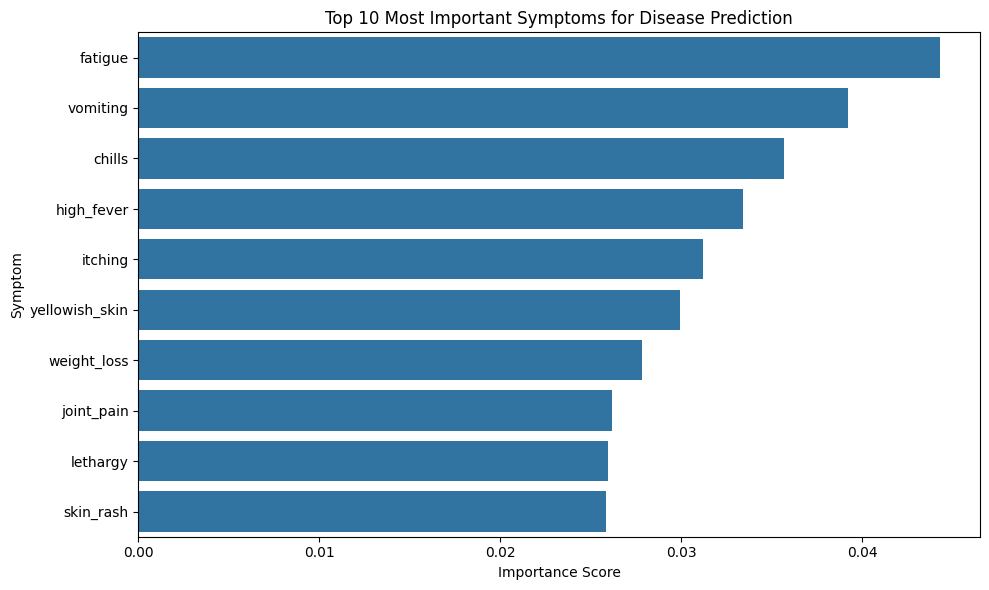

In [ ]:
# Cell 4: Preprocess symptoms data for training (Updated with data cleaning and no stratify)
# Identify symptom columns (assuming 'Disease', 'Symptom_1', 'Symptom_2', etc.)
symptom_cols = [col for col in symptoms_df.columns if 'Symptom' in col]
disease_col = 'Disease'  # Assuming this is the column name

# Clean data: Drop rows where Disease is NaN or empty
symptoms_df = symptoms_df.dropna(subset=[disease_col])
symptoms_df[disease_col] = symptoms_df[disease_col].astype(str).str.strip()

# Check class distribution
class_counts = symptoms_df[disease_col].value_counts()
print("Class distribution:")
print(class_counts)
print(f"Classes with <2 samples: {sum(class_counts < 2)}")

# Filter to classes with at least 2 samples
valid_mask = symptoms_df[disease_col].isin(class_counts[class_counts >= 2].index)
symptoms_df = symptoms_df[valid_mask]
print(f"After filtering: {len(symptoms_df)} samples")

# Collect all unique symptoms with stripping
all_symptoms = set()
for col in symptom_cols:
    if col in symptoms_df.columns:
        all_symptoms.update([str(s).strip() for s in symptoms_df[col].dropna().unique() if str(s).strip()])
all_symptoms = sorted(list(all_symptoms))  # Sort for consistent order
print(f"Total unique symptoms: {len(all_symptoms)}")

# Create binary feature matrix
X = pd.DataFrame(0, index=symptoms_df.index, columns=all_symptoms)
for idx, row in symptoms_df.iterrows():
    for col in symptom_cols:
        if col in symptoms_df.columns:
            sym = str(row[col]).strip()
            if sym and sym in all_symptoms:
                X.at[idx, sym] = 1

y = symptoms_df[disease_col]

# Train-test split without stratify to avoid issues with small classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize feature importance (top 10 symptoms)
import matplotlib.pyplot as plt
import seaborn as sns
feature_importance = pd.DataFrame({
    'Symptom': all_symptoms,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Symptom')
plt.title('Top 10 Most Important Symptoms for Disease Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Store for later use
global model_data
model_data = {
    'clf': clf,
    'all_symptoms': all_symptoms,
    'symptom_cols': symptom_cols,
    'disease_col': disease_col
}

In [ ]:
# Cell 5: Define functions for prediction and recommendations (Updated for stripped symptoms)
def predict_disease(user_symptoms):
    input_vector = pd.DataFrame(0, index=[0], columns=model_data['all_symptoms'])
    missing_symptoms = []
    for sym in user_symptoms:
        sym_str = str(sym).strip()
        if sym_str in model_data['all_symptoms']:
            input_vector[sym_str] = 1
        else:
            missing_symptoms.append(sym_str)

    if missing_symptoms:
        print(f"Warning: These symptoms not found in dataset: {missing_symptoms}")

    prediction = model_data['clf'].predict(input_vector)[0]
    probabilities = model_data['clf'].predict_proba(input_vector)[0]
    top_3 = sorted(zip(model_data['clf'].classes_, probabilities), key=lambda x: x[1], reverse=True)[:3]

    return prediction, top_3

# The get_recommendations function remains the same as before
def get_recommendations(disease):
    # Diet
    diet_row = diets_df[diets_df['Disease'] == disease]
    diet = diet_row['Diet'].iloc[0] if not diet_row.empty else ["No data available"]

    # Medication
    med_row = medications_df[medications_df['Disease'] == disease]
    meds = med_row['Medication'].iloc[0] if not med_row.empty else ["No data available"]

    # Precautions
    prec_rows = precautions_df[precautions_df['Disease'] == disease]
    if not prec_rows.empty:
        prec_cols = [col for col in prec_rows.columns if 'Precaution' in col]
        precautions = prec_rows[prec_cols].values.flatten()
        precautions = [str(p).strip() for p in precautions if pd.notna(p) and str(p).strip() != '']
    else:
        precautions = ["No data available"]

    # Workouts
    workout_rows = workout_df[workout_df['disease'] == disease]  # Assuming 'disease' column
    workouts = [str(w).strip() for w in workout_rows['workout'].tolist()] if not workout_rows.empty else ["No data available"]

    return {
        'Diet': diet,
        'Medications': meds,
        'Precautions': precautions[:4],
        'Workouts': workouts[:5]
    }

In [ ]:
from ipywidgets import Dropdown, Button, Output, VBox, HTML, Accordion
import ipywidgets as widgets
from IPython.display import clear_output, display, Markdown
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is the dataset: rows as diseases, columns as symptoms, values 0/1
# If not, replace with the actual dataframe name, e.g., model_data['symptom_df']
# Also assuming model_data['all_symptoms'] is the list of all symptom names

# Get all symptoms
all_symptoms = model_data['all_symptoms']
symptom_options = [(sym, sym) for sym in all_symptoms]

# Four cascading symptom selection widgets
symptom1 = Dropdown(options=symptom_options, description='Symptom 1:', style={'description_width': 'initial'})
symptom2 = Dropdown(options=[('Select Symptom 1 first', None)], description='Symptom 2:', style={'description_width': 'initial'}, disabled=True)
symptom3 = Dropdown(options=[('Select Symptom 2 first', None)], description='Symptom 3:', style={'description_width': 'initial'}, disabled=True)
symptom4 = Dropdown(options=[('Select Symptom 3 first', None)], description='Symptom 4:', style={'description_width': 'initial'}, disabled=True)

# Prediction button
predict_button = Button(description='Predict Disease', button_style='success', tooltip='Click to predict using the 4 selected symptoms', disabled=True)

# Output widget for results
output = Output()

def update_symptom2(change):
    if change['new'] is None:
        symptom2.options = [('Select Symptom 1 first', None)]
        symptom2.disabled = True
        symptom3.options = [('Select Symptom 2 first', None)]
        symptom3.disabled = True
        symptom4.options = [('Select Symptom 3 first', None)]
        symptom4.disabled = True
        predict_button.disabled = True
        return

    # Get rows where symptom1 is present
    relevant_rows = X[X[change['new']] == 1].index
    # Get co-occurring symptoms (excluding the selected one)
    co_occurring = [col for col in all_symptoms if col != change['new'] and X.loc[relevant_rows, col].sum() > 0]
    symptom2.options = [(sym, sym) for sym in co_occurring] + [(None, None)]
    symptom2.value = None
    symptom2.disabled = False
    # Reset next ones
    symptom3.options = [('Select Symptom 2 first', None)]
    symptom3.disabled = True
    symptom4.options = [('Select Symptom 3 first', None)]
    symptom4.disabled = True
    predict_button.disabled = True

def update_symptom3(change):
    if change['new'] is None or symptom1.value is None:
        symptom3.options = [('Select Symptom 2 first', None)]
        symptom3.disabled = True
        symptom4.options = [('Select Symptom 3 first', None)]
        symptom4.disabled = True
        predict_button.disabled = True
        return

    # Get rows where both symptom1 and symptom2 are present
    relevant_rows = X[(X[symptom1.value] == 1) & (X[change['new']] == 1)].index
    if len(relevant_rows) == 0:
        symptom3.options = [('No co-occurring symptoms', None)]
        symptom3.disabled = False
        return

    # Get co-occurring symptoms (excluding previous selections)
    prev_syms = [symptom1.value, change['new']]
    co_occurring = [col for col in all_symptoms if col not in prev_syms and X.loc[relevant_rows, col].sum() > 0]
    symptom3.options = [(sym, sym) for sym in co_occurring] + [(None, None)]
    symptom3.value = None
    symptom3.disabled = False
    # Reset next one
    symptom4.options = [('Select Symptom 3 first', None)]
    symptom4.disabled = True
    predict_button.disabled = True

def update_symptom4(change):
    if change['new'] is None or symptom1.value is None or symptom2.value is None:
        symptom4.options = [('Select Symptom 3 first', None)]
        symptom4.disabled = True
        predict_button.disabled = True
        return

    # Get rows where symptom1, symptom2, and symptom3 are present
    relevant_rows = X[(X[symptom1.value] == 1) & (X[symptom2.value] == 1) & (X[change['new']] == 1)].index
    if len(relevant_rows) == 0:
        symptom4.options = [('No co-occurring symptoms', None)]
        symptom4.disabled = False
        return

    # Get co-occurring symptoms (excluding previous selections)
    prev_syms = [symptom1.value, symptom2.value, change['new']]
    co_occurring = [col for col in all_symptoms if col not in prev_syms and X.loc[relevant_rows, col].sum() > 0]
    symptom4.options = [(sym, sym) for sym in co_occurring] + [(None, None)]
    symptom4.value = None
    symptom4.disabled = False
    predict_button.disabled = True

def enable_predict(change):
    if (symptom1.value is not None and
        symptom2.value is not None and
        symptom3.value is not None and
        symptom4.value is not None):
        predict_button.disabled = False
    else:
        predict_button.disabled = True

# Attach observers
symptom1.observe(update_symptom2, names='value')
symptom2.observe(update_symptom3, names='value')
symptom3.observe(update_symptom4, names='value')
symptom4.observe(enable_predict, names='value')
symptom3.observe(enable_predict, names='value')
symptom2.observe(enable_predict, names='value')
symptom1.observe(enable_predict, names='value')

def on_predict_clicked(b):
    with output:
        clear_output()
        selected_symptoms = [symptom1.value, symptom2.value, symptom3.value, symptom4.value]
        if None in selected_symptoms:
            print("Please select all four symptoms.")
            return

        print(f"Selected Symptoms: {selected_symptoms}")

        predicted_disease, top_3 = predict_disease(selected_symptoms)
        print(f"\nPredicted Disease: **{predicted_disease}**")
        print("Top 3 Probable Diseases:")
        for disease, prob in top_3:
            print(f"  - {disease}: {prob:.2f}")

        recommendations = get_recommendations(predicted_disease)

        # Create HTML lists for recommendations
        def create_list(items, title):
            if items == ["No data available"]:
                return HTML(value=f"<h4>{title}</h4><p>No data available</p>")
            else:
                list_html = "<h4>" + title + "</h4><ul>"
                for item in items:
                    list_html += f"<li>{item}</li>"
                list_html += "</ul>"
                return HTML(value=list_html)

        diet_html = create_list(recommendations['Diet'], 'Diet Recommendations')
        med_html = create_list(recommendations['Medications'], 'Medication Recommendations')
        prec_html = create_list(recommendations['Precautions'], 'Precautions')
        workout_html = create_list(recommendations['Workouts'], 'Workout Tips')

        # Accordion for recommendations
        accordion = Accordion(children=[diet_html, med_html, prec_html, workout_html])
        accordion.set_title(0, 'Diet')
        accordion.set_title(1, 'Medications')
        accordion.set_title(2, 'Precautions')
        accordion.set_title(3, 'Workouts')

        display(accordion)

        # Simple bar chart for top diseases
        top_diseases = [d for d, p in top_3]
        top_probs = [p for d, p in top_3]
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.barh(top_diseases, top_probs)
        ax.set_xlabel('Probability')
        ax.set_title('Top 3 Disease Probabilities')
        plt.tight_layout()
        plt.show()

predict_button.on_click(on_predict_clicked)

# Display the dashboard
display(Markdown("### Disease Prediction Dashboard (Cascading Symptoms - Select Sequentially)"))
display(symptom1)
display(symptom2)
display(symptom3)
display(symptom4)
display(predict_button)
display(output)

### Disease Prediction Dashboard (Cascading Symptoms - Select Sequentially)

Dropdown(description='Symptom 1:', options=(('abdominal_pain', 'abdominal_pain'), ('acidity', 'acidity'), ('al…

Dropdown(description='Symptom 2:', disabled=True, options=(('Select Symptom 1 first', None),), style=Descripti…

Dropdown(description='Symptom 3:', disabled=True, options=(('Select Symptom 2 first', None),), style=Descripti…

Dropdown(description='Symptom 4:', disabled=True, options=(('Select Symptom 3 first', None),), style=Descripti…

Button(button_style='success', description='Predict Disease', disabled=True, style=ButtonStyle(), tooltip='Cli…

Output()